# Plotting age distributions with respect to genotype groups

[u'age23', u'age24', u'age33', u'age34', u'age44']
age23 W:0.9705 p:0.0222 102 subjects between 46 and 75
age24 W:0.9539 p:0.0769 44 subjects between 45 and 71
age33 W:0.9613 p:0.0005 143 subjects between 45 and 75
age34 W:0.9640 p:0.0004 160 subjects between 45 and 74
age44 W:0.9306 p:0.0013 65 subjects between 45 and 67


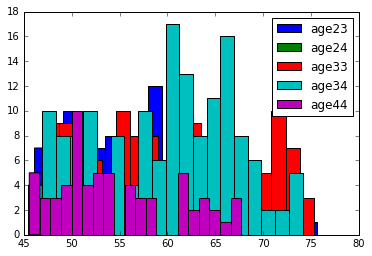

In [1]:
import pandas as pd
data = pd.read_excel('/home/grg/spm/designmat/fullmatrix.xls')
from matplotlib import pyplot as plt
%matplotlib inline
ages = [e for e in data.columns if 'age' in e and not 'sq' in e]
print ages
from scipy import stats
data2 = {}
for each in ages:
    x = [int(i)/365.25 for i in data[each].tolist() if i>0]
    data2[each] = x
    plt.hist(x, bins=20)
    print each, 'W:%.4f p:%.4f'%stats.shapiro(x), len(x), 'subjects between', int(min(x)), 'and', int(max(x))

plt.legend(ages)
plt.show()
    

For two of the 5 groups, the Shapiro test p-value is lower than 1e-3, which means that the distributions of these two groups can't be considered as normal.